# Прогнозирование отказов фрезерного станка

<b>Цель.</b> Разработать модель машинного обучения, которая будет прогнозировать отказы оборудования, что позволит:
 * увеличить производственную эффективность за счёт своевременного проведения профилактической работы,
что способствует снижению временных простоев и увеличению общей производительности оборудования,
 * повысить качество продукции за счёт минимизации дефектов, вызванных нештатной работой оборудования,
 * улучшить безопасность за счёт предотвращения возможных аварийных ситуаций.

# Краткое описание проекта

В ходе выполнения проекта:
</br>1. Провёл анализ датасета: проанализировал объём данных и его качество, выявил и обработал ошибки в данных.
</br>2. Построил графики (выполнил EDA). Нашёл данные, имеющие высокую корреляцию. Обнаружил сильный дисбаланс в данных.
</br>3. Для обучения модели применил стандартизацию данных StandardScaler(), stratify ддя корректного разбиения данных, технику балансировки over-sampling для синтетического увеличения примеров в меньшем классе.
</br>4. Обучил несколько моделей ('Логистическая регрессия', 'Метод ближайших соседей', 'Дерево решений', 'Случайны лес', 'Градиентный бустинг') и сравнил получившиеся метрики качества (Accuracy, Precision, Recall, F1-Score, ROC-AUC).
</br>5. Попробовал обучиться модели с предварительной настройкой гиперпараметров, что не привело к значительным улучшением моделей.

# Выполнение проекта

1. Импортируем основные библиотеки.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

2. Считываем данные из CSV-файла. Выводим первые 5 строк, чтобы убедиться, что данные считались с локального файла.

In [2]:
df = pd.read_csv('ai4i2020.csv')
pd.set_option('display.max_columns', None)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Целевая переменная - <b>Machine failure</b> (метка «сбой машины», которая указывает, верен ли сбой машины в этой конкретной точке данных).

Приведём описание признаков:
 * <b>UDI</b> - уникальный идентификатор в диапазоне от 1 до 10000.
 * <b>Product ID</b> - маркировка качества и серийный номер.
 * <b>Type</b> - маркировка качества, L, M или H для низкого (50 % всех продуктов), среднего (30 %) и высокого (20 %) качества.
 * <b>Air temperature [K]</b> - температура воздуха [К].
 * <b>Process temperature [K]</b> - температура процесса [К].
 * <b>Rotational speed [rpm]</b> - скорость вращения [об/мин]: рассчитано на основе мощности 2860 Вт с наложением нормально распределённого шума.
 * <b>Torque [Nm]</b> - крутящий момент [Нм], значения крутящего момента обычно распределяются в районе 40 Нм с SD = 10 Нм и без отрицательных значений.
 * <b>Tool wear [min]</b> - износ инструмента [мин], варианты качества H/M/L увеличивают износ инструмента, используемого в процессе, на 5/3/2 минуты.
 * <b>TWF</b> - тип отказа, отказ из-за износа инструмента.
 * <b>HDF</b> - тип отказа, нарушение отвода тепла.
 * <b>PWF</b> - тип отказа, сбой мощности.
 * <b>OSF</b> - тип отказа, отказ от перенапряжения.
 * <b>RNF</b> - тип отказа, случайные сбои.

Для удобства заменим заголовки в датасете.

In [3]:
# Словарь с новыми названиями заголовков
new_column_names = {
    'Type': 'type', # Маркировка качества
    'Air temperature [K]': 'temp_air', # Температура воздуха [K]
    'Process temperature [K]': 'temp_proc', # Температура процесса [K]
    'Rotational speed [rpm]': 'spd_rotat', # Скорость вращения [об/мин]
    'Torque [Nm]': 'torque', # Крутящий момент [Нм]
    'Tool wear [min]': 'wear_tool', # Износ инструмента [мин]
    'Machine failure': 'target', # Отказ
}

# Замена названий столбцов
df = df.rename(columns=new_column_names)

3. Посмотрим на количество записей в файле.

In [4]:
df.shape

(10000, 14)

4. Посмотрим, какого типа эти данные:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   UDI         10000 non-null  int64  
 1   Product ID  10000 non-null  object 
 2   type        10000 non-null  object 
 3   temp_air    10000 non-null  float64
 4   temp_proc   10000 non-null  float64
 5   spd_rotat   10000 non-null  int64  
 6   torque      10000 non-null  float64
 7   wear_tool   10000 non-null  int64  
 8   target      10000 non-null  int64  
 9   TWF         10000 non-null  int64  
 10  HDF         10000 non-null  int64  
 11  PWF         10000 non-null  int64  
 12  OSF         10000 non-null  int64  
 13  RNF         10000 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 1.1+ MB


Видим, что пропущенные значения отсутствуют. Есть категориальные признаки.

In [6]:
# Просмотр количества уникальных записей для каждого признака
df.apply(lambda x: x.nunique())

UDI           10000
Product ID    10000
type              3
temp_air         93
temp_proc        82
spd_rotat       941
torque          577
wear_tool       246
target            2
TWF               2
HDF               2
PWF               2
OSF               2
RNF               2
dtype: int64

5. Уберём из датасета уникальные значения UDI и Product ID.

In [7]:
# Удаление признаков
columns_to_drop = ['UDI', 'Product ID']
df = df.drop(columns=columns_to_drop, axis=1)

# Вывод обновленного датасета
df.head()

,type,temp_air,temp_proc,spd_rotat,torque,wear_tool,target,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# EDA

1. Посмотрим на соотношение значений целевой переменной.

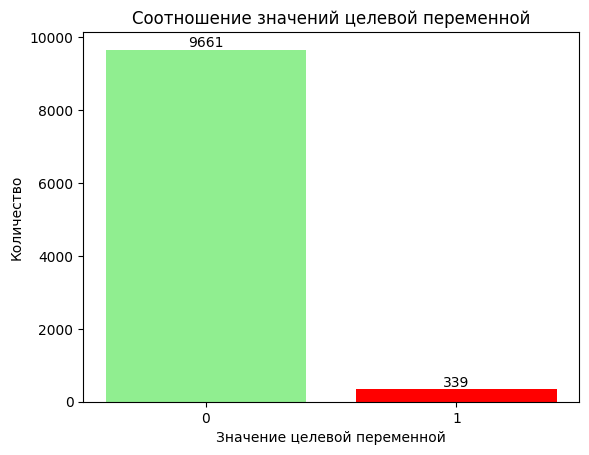

In [8]:
# Создаем столбчатую диаграмму
fig, ax = plt.subplots()
target_value_counts = df['target'].value_counts().sort_index()
ax.bar(target_value_counts.index, target_value_counts, color=['lightgreen', 'red'])

# Настроим ось x для отображения только значений 0 и 1
ax.set_xticks([0, 1])
ax.set_xticklabels([0, 1])

# Настройка заголовка и осей
plt.title('Соотношение значений целевой переменной')
plt.xlabel('Значение целевой переменной')
plt.ylabel('Количество')

# Добавим числовые значения на график
for i, value in enumerate(target_value_counts):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Отображаем график
plt.show()

Видим, что число отказов значительно меньше случаев нормальной работы, т.е. целевая переменная сильно несбалансирована.
</br>1. Это потребует от нас соответсвующего распределения данных при тестировании и обучении.
</br>2. Так же потребуется применять алгоритмы машинного обучения, обладающие встроенной устойчивостью к дисбалансу классов,
такие как алгоритмы случайного леса и градиентного бустинга.
</br>3. Кроме того будем использовать метрики, учитывающие дисбаланс классов, такие как recall, ROC-AUC.

2. Проверим данные на корректность соответсвия отказа и типа отказа.

In [9]:
# Суммируем столбцы 'TWF', 'HDF', 'PWF', 'OSF', 'RNF' и добавляем результат в новый столбец 'Total'
df['type_target'] = df['TWF'] + df['HDF'] + df['PWF'] + df['OSF'] + df['RNF']

# Выводим обновленный датасет
df.head()

,type,temp_air,temp_proc,spd_rotat,torque,wear_tool,target,TWF,HDF,PWF,OSF,RNF,type_target
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0


In [10]:
failure_data = df[['target','type_target']][df['target'] == 0]
failure_data.value_counts()

target  type_target
0       0              9643
        1                18
Name: count, dtype: int64

In [11]:
failure_data_type = df[['target','type_target']][df['type_target'] == 0]
failure_data_type.value_counts()

target  type_target
0       0              9643
1       0                 9
Name: count, dtype: int64

Видим, что для 18 записей, у которых указано отсутствие сбоя указан тип отказа.
</br>А для 9 записей тип отказа не указан, но при этом запись помечена, как сбой.
</br>Удилим эти записи из датасета.

In [12]:
df = df.drop(df[
    ((df.type_target == 1) & (df.target == 0)) | ((df.target == 1) & (df.type_target == 0))
].index)

df.shape

(9973, 13)

Также уберём типы отказов,
т.к. в данном проекте мы будет предсказывать отказ оборудования без учёта типа этого отказа.

In [13]:
columns_to_drop = ['type_target', 'type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df = df.drop(columns=columns_to_drop, axis=1)

In [14]:
df.head()

,temp_air,temp_proc,spd_rotat,torque,wear_tool,target
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0


3.	Построим диаграммы распределения числовых признаков с использованием числовой переменной для группировки и раскраски данных.

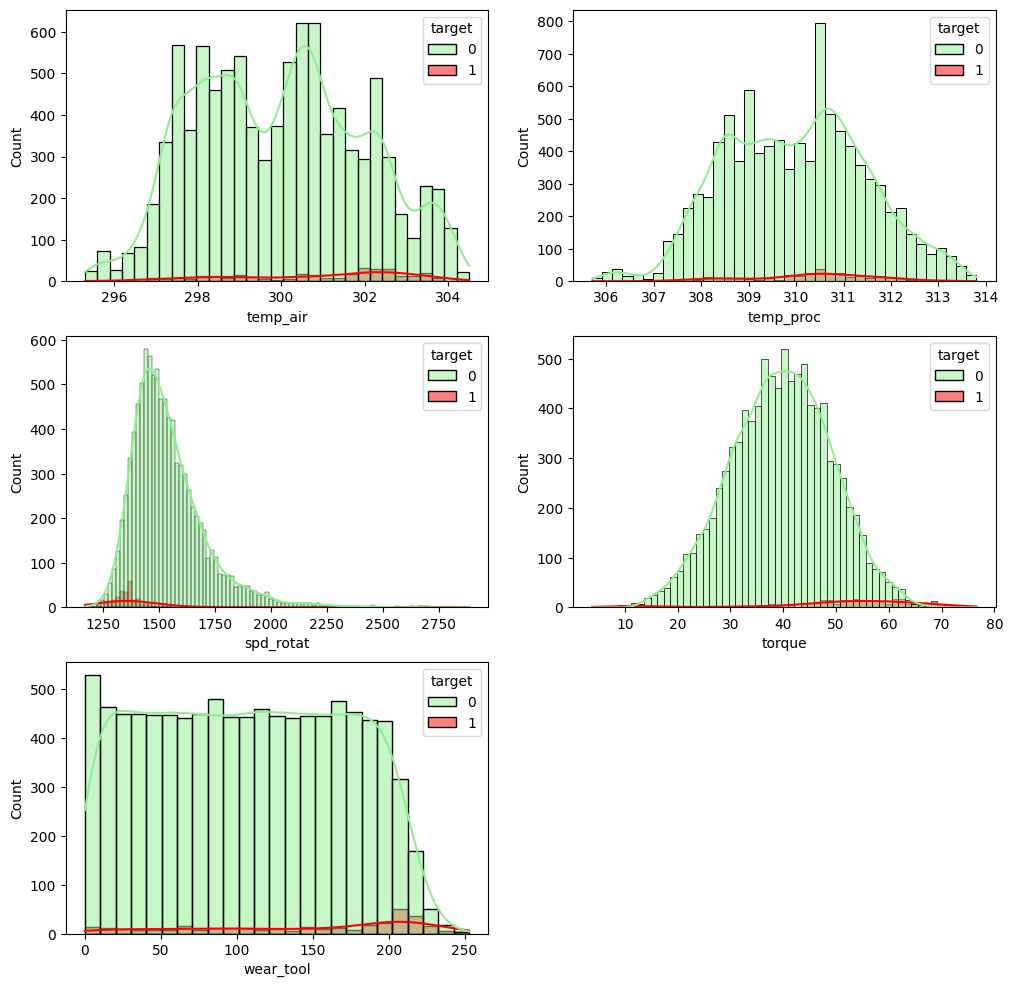

In [15]:
# Создаем графики с расцветкой 0 - зелёный, 1 - красный, в 2 столбца на всю ширину экрана
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Создаем гистограмму с прозрачным зеленым цветом
sns.histplot(data=df, x="temp_air", hue="target", kde=True, ax=axes[0, 0], palette={0: 'lightgreen', 1: 'red'})
sns.histplot(data=df, x="temp_proc", hue="target", kde=True, ax=axes[0, 1], palette={0: 'lightgreen', 1: 'red'})
sns.histplot(data=df, x="spd_rotat", hue="target", kde=True, ax=axes[1, 0], palette={0: 'lightgreen', 1: 'red'})
sns.histplot(data=df, x="torque", hue="target", kde=True, ax=axes[1, 1], palette={0: 'lightgreen', 1: 'red'})
sns.histplot(data=df, x="wear_tool", hue="target", kde=True, ax=axes[2, 0], palette={0: 'lightgreen', 1: 'red'})

# Удаляем последний пустой график
fig.delaxes(axes[2, 1])

# Отображаем графики
plt.show()

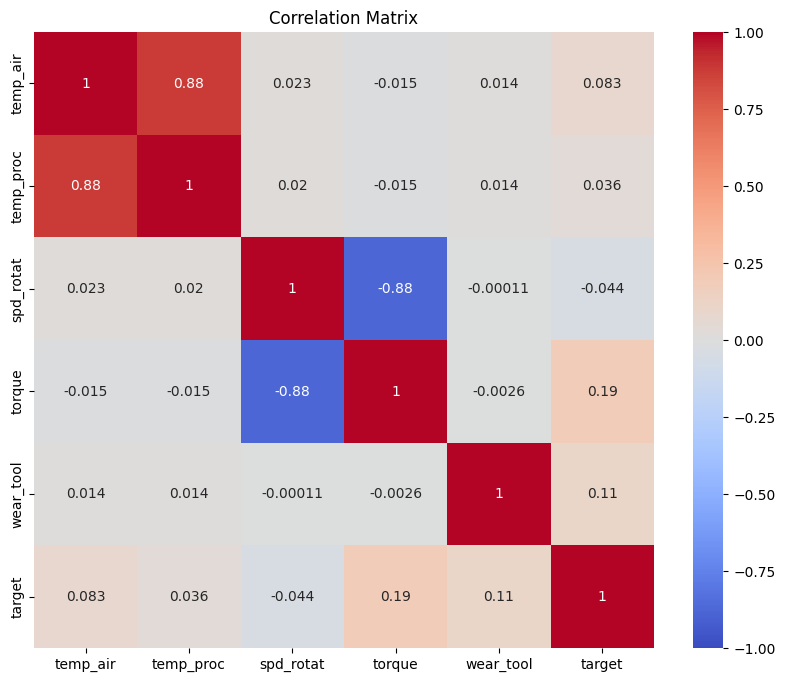

In [16]:
# Вычисляем матрицу корреляции
corr_matrix = df.corr()

# Создаем тепловую карту корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Парные графики, а также график корреляции показывают две пары переменных,
которые сильно коррелируют друг с другом:
  * Температура воздуха и температура процесса (температура процесса пропорциональна температуре воздуха),
  * Скорость вращения и крутящий момент (скорость вращения обратнопропорциональна крутящему моменту).

# Обучение модели

Так как у нас сильный дисбаланс классов, а так же есть сильно коррелирующие признаки обучение модели выполним следующим образом:
</br>1. Применим стандартизацию данных <b>StandardScaler()</b>.
</br>2. При разделении данных применим <b>stratify</b>.
Данные будут разбиты таким образом, чтобы распределение классов в каждой части (обучающей и тестовой выборках)
было было аналогично исходным данным.
</br>3. Применим технику балансировки <b>over-sampling</b> количества значений в классе,
которая увеличивает количество примеров в меньшем классе. Для over-sampling используем метод <b>SMOTE</b>.

In [17]:
df['target'].value_counts()

target
0    9643
1     330
Name: count, dtype: int64

In [18]:
X = df.drop('target', axis=1)
y = df['target']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('Целевые значения для обучения y_train:', y_train.value_counts())
print('Целевые значения для теста y_test:', y_test.value_counts())

Целевые значения для обучения y_train: target
0    6750
1     231
Name: count, dtype: int64
Целевые значения для теста y_test: target
0    2893
1      99
Name: count, dtype: int64


In [19]:
# Нормализация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_test

(array([[-0.25472608, -0.47642643,  1.99803079, -1.59400236,  0.68923469],
        [-1.15194736, -1.75783624,  0.57076298, -0.34560323, -0.81664346],
        [ 0.19388456,  0.13055717,  0.40544239, -0.30565446,  1.94413314],
        ...,
        [-0.80302797, -0.34154118, -0.30543617,  0.17373081,  0.1872753 ],
        [ 1.34033398,  0.33288503, -0.15664764, -0.22575692, -0.73821231],
        [ 0.39326707,  1.14219649, -0.27237205,  0.64312888,  1.72452591]]),
 array([[-0.95256485, -0.74619691, -0.95018649,  0.19370519,  0.09315792],
        [ 0.19388456, -0.27409856, -0.88405826,  1.45209152,  0.234334  ],
        [-1.00241048, -1.69039362, -0.6195453 ,  0.36348747, -0.09507685],
        ...,
        [-1.20179298, -0.34154118,  0.93446829, -0.77505253, -0.65978115],
        [-0.75318234, -0.20665594, -0.0905194 ,  0.4633594 , -0.377429  ],
        [ 1.14095147,  1.27708174, -0.1731797 ,  0.23365396,  0.81472453]]))

In [20]:
# Применение SMOTE
smote = SMOTE()

# В этом коде происходит применение метода SMOTE (Synthetic Minority Over-sampling Technique) к обучающему набору данных.
# После использования метода fit_resample объекта, созданного из класса SMOTE, данные из обучающего набора,
# которые включают матрицу признаков X_train и соответствующие целевые значения y_train,
# будут изменены для создания нового набора данных X_train_sm и y_train_sm,
# в котором присутствует дополнительное количество синтетических примеров, сохраняя исходные целевые значения.

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(X_train_sm.shape)
print(y_train_sm.shape)

y_train_sm_series = pd.Series(y_train_sm)
class_counts = y_train_sm_series.value_counts()
print(class_counts)

(13500, 5)
(13500,)
target
0    6750
1    6750
Name: count, dtype: int64


In [21]:
# Инициализация моделей
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LGBMClassifier(verbosity=-1)
]

model_names = ['Логистическая регрессия', 'Метод ближайших соседей', 'Дерево решений', 'Случайны лес', 'Градиентный бустинг']

# Создаем DataFrame для хранения результатов
results = pd.DataFrame(columns=['Model', 'Sampling', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

# Обучение и оценка моделей
# используем цикл for для перебора пар моделей и их имен из списка models и списка model_names.
for model, model_name in zip(models, model_names):
    # Используем исходные данные
    model.fit(X_train, y_train) # обучаем модель на обучающих данных X_train и y_train.
    y_pred = model.predict(X_test) # предсказываем значения для тестовых данных X_test с помощью модели.
    
    # добавляем результаты модели в DataFrame results:
    # имя модели, метку 'No Sampling', значения метрик точности, точности, полноты, F1-Score и ROC-AUC.
    results.loc[len(results)] = [model_name, 'No Sampling',
                                  accuracy_score(y_test, y_pred), 
                                  precision_score(y_test, y_pred), 
                                  recall_score(y_test, y_pred), 
                                  f1_score(y_test, y_pred), 
                                  roc_auc_score(y_test, y_pred)]
    
    # Используем данные с применением SMOTE
    smote = SMOTE()
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    model.fit(X_train_sm, y_train_sm)
    y_pred_sm = model.predict(X_test)
    results.loc[len(results)] = [model_name, 'SMOTE',
                                  accuracy_score(y_test, y_pred_sm), 
                                  precision_score(y_test, y_pred_sm), 
                                  recall_score(y_test, y_pred_sm), 
                                  f1_score(y_test, y_pred_sm), 
                                  roc_auc_score(y_test, y_pred_sm)]
    
results

,Model,Sampling,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Логистическая регрессия,No Sampling,0.971257,0.782609,0.181818,0.295082,0.590045
1,Логистическая регрессия,SMOTE,0.819519,0.135537,0.828283,0.232955,0.823751
2,Метод ближайших соседей,No Sampling,0.975267,0.857143,0.303030,0.447761,0.650651
3,Метод ближайших соседей,SMOTE,0.941176,0.340249,0.828283,0.482353,0.886661
4,Дерево решений,No Sampling,0.979278,0.717647,0.616162,0.663043,0.803933
5,Дерево решений,SMOTE,0.965241,0.483871,0.757576,0.590551,0.864961
6,Случайны лес,No Sampling,0.984291,0.882353,0.606061,0.718563,0.801648
7,Случайны лес,SMOTE,0.972259,0.556338,0.797980,0.655602,0.888102
8,Градиентный бустинг,No Sampling,0.983289,0.855072,0.595960,0.702381,0.796251
9,Градиентный бустинг,SMOTE,0.972928,0.562500,0.818182,0.666667,0.898203


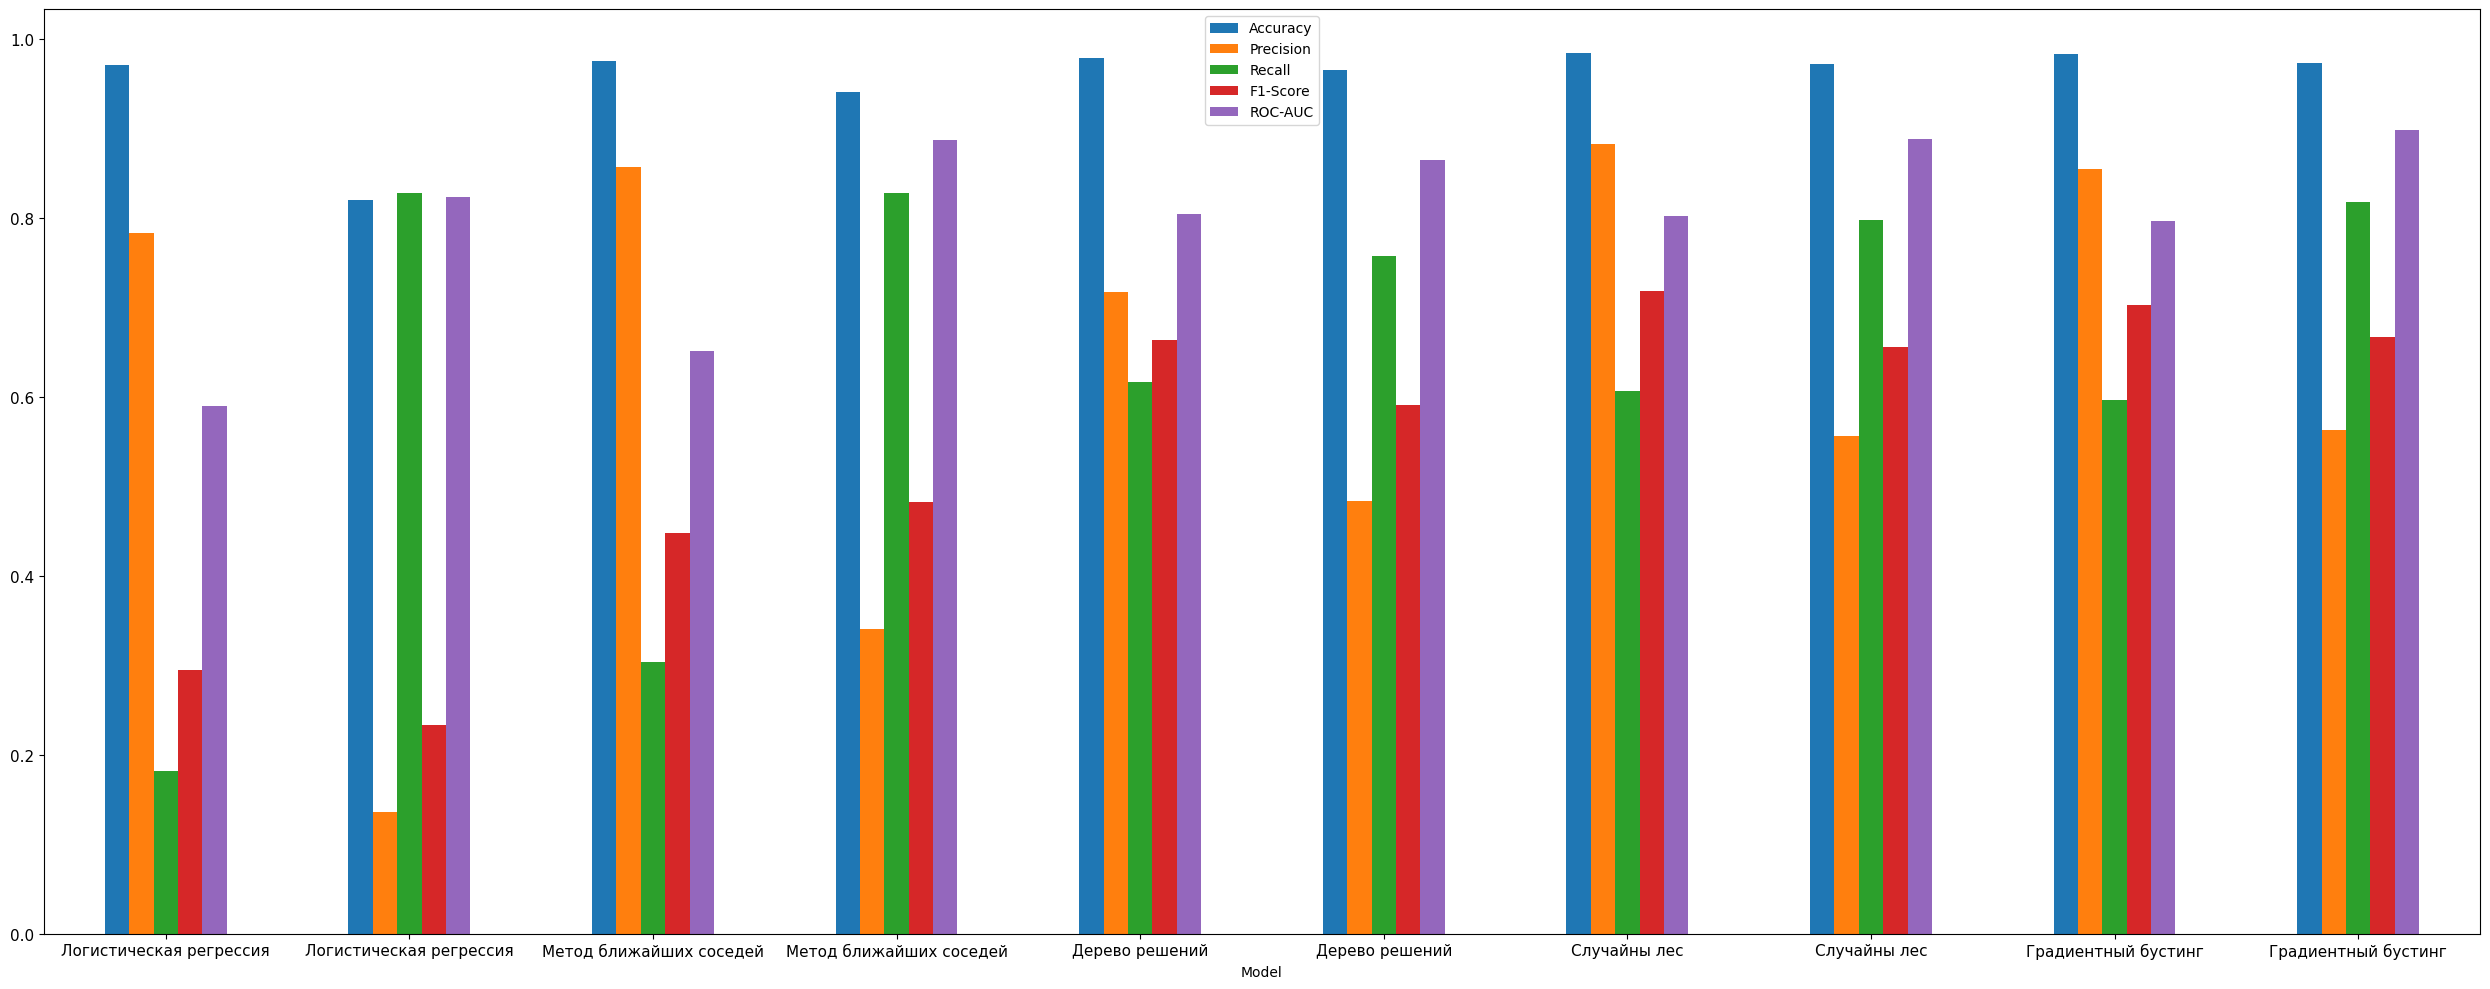

In [22]:
df_test = pd.DataFrame(results)

# Создадим гистограмму для каждой модели и метода выборки
fig, ax = plt.subplots(figsize=(25, 10))

df_test.set_index('Model', inplace=True)
df_test.plot(kind='bar', ax=ax, rot=0, fontsize=11)
ax.legend(loc='upper center')

plt.tight_layout()
plt.show()

<b>Основываясь на полученных данных, можно сделать следующие выводы:</b>
</br>1. Использование метода <b>SMOTE показывает более высокую величину показателей Recall (полнота) и ROC-AUC</b>
по сравнению с отсутствием сэмплирования для всех рассмотренных моделей
("Логистическая регрессия", "Метод ближайших соседей", "Дерево решений", "Случайный лес", "LGBM").
Это указывает на то, что <b>использование SMOTE улучшает способность моделей определять редкие положительные примеры, что отражается в повышении величин Recall и ROC-AUC</b>.
</br>2. Вместе с тем, метрики качества, такие как Accuracy (доля верно классифицированных объектов), Precision (точность) и F1-Score, ниже для SMOTE, чем для NO Sampling для всех рассмотренных моделей.
<b>Снижение показателей Accuracy, Precision и F1-Score может быть связано с использованием большого количества синтетически сгенерированных примеров, что приводит к дополнительному шуму в обучающий набор данных, а также может привести к переобучению модели или усложнению границы принятия решения, что в свою очередь увеличивает количество ложноположительных и ложноотрицательных результатов</b>.
</br>3. Общий тренд показывает, что, несмотря на некоторые компромиссы,
<b>SMOTE в целом может улучшить объективность модели,
особенно если цель заключается в достижении более высокой полноты Recall или более высокого ROC-AUC</b>.
</br>4. С другой стороны, <b>если целью является точность прогноза, модели лучше обучать без сэмплирования</b>.
</br>5. Кроме того, стоит отметить, что <b>"Градиентный бустинг" показывает наилучшие результаты</b> с точки зрения метрик качества среди всех рассмотренных моделей.

Попробуем поработать с гиперпараметрами и посмотреть на метрики качества моделей.

In [23]:
# Инициализация моделей с наборами гиперпараметров для подбора
models = [
    (LogisticRegression(), {
        # Параметр C является коэффициентом штрафа в регуляризации.
        # Значение C влияет на степень регуляризации модели и может влиять на ее способность к обобщению.
        # В данном случае, мы указываем различные значения для параметра C (от 0.001 до 100),
        # чтобы найти оптимальное значение, которое обеспечит наилучшую производительность модели.
        'C': [0.001, 0.01, 0.1, 1, 2, 10, 100], 
        # Параметр 'penalty' означает штрафную функцию, которая используется для регуляризации модели.
        # Штрафная функция 'l2' добавляет квадратичный штраф к ошибке квадратичной аппроксимации,
        # что помогает предотвратить переобучение модели.
        'penalty': ['l2']
    }),
    (KNeighborsClassifier(), {
        # Параметр 'n_neighbors' означает количество ближайших соседей,
        # которые будут использоваться для классификации новых наблюдений.
        'n_neighbors': [3, 4, 5, 6, 7],
        # Параметр 'weights' означает способ взвешивания голосов ближайших соседей при классификации новых наблюдений.
        # В данном случае, мы указываем, что веса должны быть 'uniform' и 'distance'.
        # Вес 'uniform' означает, что все ближайшие соседи имеют одинаковый вес,
        # независимо от их расстояния до нового наблюдения.
        # Вес 'distance' означает, что ближайшие соседи имеют больший вес, чем более далекие соседи.
        'weights': ['uniform', 'distance']
    }),
    (DecisionTreeClassifier(), {
        # Параметр 'max_depth' означает максимальную глубину дерева, которую может достичь дерево решений.
        # Значение None означает, что дерево может быть неограниченной глубины.
        'max_depth': [5, 9, 10, 11, 15, None],
        # Параметр 'criterion' означает критерий, который используется для выбора лучшего разделения на каждом уровне дерева.
        # В данном случае, мы указываем, что критерий должен быть 'gini' и 'entropy'.
        # Критерий 'gini' минимизирует дисперсию ошибок, а критерий 'entropy' минимизирует энтропию ошибок.
        'criterion': ['gini', 'entropy']
    }),
    (RandomForestClassifier(), {
        # Параметр 'n_estimators' означает количество деревьев в алгоритме случайный лес.
        'n_estimators': [200, 300, 400, 500, 600],
        # Параметр 'max_depth' означает максимальную глубину дерева, которую может достичь каждое дерево в случайном лесу.
        # Значение None означает, что дерево может быть неограниченной глубины.
        'max_depth': [5, 9, 10, 11, 15, None]
    }),
    (LGBMClassifier(verbosity=-1), {
        # Параметр 'learning_rate' означает скорость обучения, которая определяет,
        # насколько быстро модель будет обновлять параметры при каждом шаге обучения.
        'learning_rate': [0.05, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5],
        # Параметр 'n_estimators' означает количество деревьев в градиентном бустинге.
        'n_estimators': [200, 300, 400, 500]
    })
]

model_names = ['Логистическая регрессия', 'Метод ближайших соседей', 'Дерево решений', 'Случайны лес', 'Градиентный бустинг']

# Создаем DataFrame для хранения результатов
results = pd.DataFrame(columns=['Model', 'Sampling', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

for (model, param_grid), model_name in zip(models, model_names):
    # Подбор гиперпараметров
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, error_score='raise')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Выводим лучшие параметры
    best_params = grid_search.best_params_
    print('Лучшие параметры для', model_name, ':', best_params)
    
    # добавляем результаты модели в DataFrame results:
    # имя модели, метку 'No Sampling', значения метрик точности, точности, полноты, F1-Score и ROC-AUC.
    results.loc[len(results)] = [model_name, 'No Sampling',
                                  accuracy_score(y_test, y_pred), 
                                  precision_score(y_test, y_pred), 
                                  recall_score(y_test, y_pred), 
                                  f1_score(y_test, y_pred), 
                                  roc_auc_score(y_test, y_pred)]
    
    # Производим оценку модели с использованием SMOTE
    smote = SMOTE()
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    best_model.fit(X_train_sm, y_train_sm)
    y_pred_sm = best_model.predict(X_test)
    results.loc[len(results)] = [model_name, 'SMOTE',
                                  accuracy_score(y_test, y_pred_sm), 
                                  precision_score(y_test, y_pred_sm), 
                                  recall_score(y_test, y_pred_sm), 
                                  f1_score(y_test, y_pred_sm), 
                                  roc_auc_score(y_test, y_pred_sm)]

results

Лучшие параметры для Логистическая регрессия : {'C': 1, 'penalty': 'l2'}
Лучшие параметры для Метод ближайших соседей : {'n_neighbors': 5, 'weights': 'distance'}
Лучшие параметры для Дерево решений : {'criterion': 'gini', 'max_depth': 9}
Лучшие параметры для Случайны лес : {'max_depth': 11, 'n_estimators': 400}
Лучшие параметры для Градиентный бустинг : {'learning_rate': 0.1, 'n_estimators': 400}


,Model,Sampling,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Логистическая регрессия,No Sampling,0.983289,0.855072,0.595960,0.702381,0.796251
1,Логистическая регрессия,SMOTE,0.818850,0.133884,0.818182,0.230114,0.818527
2,Метод ближайших соседей,No Sampling,0.983289,0.855072,0.595960,0.702381,0.796251
3,Метод ближайших соседей,SMOTE,0.942179,0.341880,0.808081,0.480480,0.877424
4,Дерево решений,No Sampling,0.983289,0.855072,0.595960,0.702381,0.796251
5,Дерево решений,SMOTE,0.946858,0.352941,0.727273,0.475248,0.840823
6,Случайны лес,No Sampling,0.983289,0.855072,0.595960,0.702381,0.796251
7,Случайны лес,SMOTE,0.957888,0.426230,0.787879,0.553191,0.875792
8,Градиентный бустинг,No Sampling,0.983289,0.855072,0.595960,0.702381,0.796251
9,Градиентный бустинг,SMOTE,0.977273,0.626016,0.777778,0.693694,0.880939


По результатам видим, что хорошего прироста в качестве моделей мы не получили.
</br>Практически для всех моделей разница составили в сотые-тысячные доли в сторону улучшения или ухудшения.
</br>Как и в первом случае лучше всего показывает себя <b>Градиентный бустинг</b>.

</br><b>No Sampling</b>:
  * <b>Логистическая регрессия</b> - Практически все показатели улучшились на десятые доли (за исключением Accuracy, сотые доли).
  * <b>Метод ближайших соседей</b> - Улучшились все показатели, за исключением Precision, значение которого снизилось на тысячные доли.
  * <b>Дерево решений</b> - Accuracy, Precision, F1-Score улучшились, Recall, ROC-AUC ухудшились на сотые доли.
  * <b>Случайны лес</b> - все показатели ухудшились на сотые доли.
  * <b>Градиентный бустинг</b> - показатели не изменились.

<b>SMOTE</b>::
  * <b>Логистическая регрессия</b> - все показатели ухудшились на тысячные доли.
  * <b>Метод ближайших соседей</b> - Accuracy, Precision улучшились, Recall, F1-Score, ROC-AUC ухудшились на тысячные доли.
  * <b>Дерево решений</b> - все показатели ухудшились на сотые-тысячные доли.
  * <b>Случайны лес</b> - все показатели ухудшились на сотые-тысячные доли.
  * <b>Градиентный бустинг</b> - Accuracy, Precision, F1-Score улучшились, Recall, ROC-AUC ухудшились на сотые доли.